In [10]:
import time

import torch
import torch.nn as nn

def get_llama(model):
    import torch
    def skip(*args, **kwargs):
        pass
    torch.nn.init.kaiming_uniform_ = skip
    torch.nn.init.uniform_ = skip
    torch.nn.init.normal_ = skip
    from transformers import LlamaForCausalLM
    model = LlamaForCausalLM.from_pretrained(model, torch_dtype='auto')
    model.seqlen = 2048
    return model

model = get_llama("huggyllama/llama-7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
weights = []
layer = model.model.layers[0]
weights.append(layer.self_attn.q_proj.weight.clone())
weights.append(layer.self_attn.k_proj.weight.clone())
weights.append(layer.self_attn.v_proj.weight.clone())
weights.append(layer.self_attn.o_proj.weight.clone())

weights

[tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
         [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
         [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
         ...,
         [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
         [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
         [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]],
        dtype=torch.float16, grad_fn=<CloneBackward0>),
 tensor([[-0.0316,  0.0256, -0.0027,  ...,  0.0219, -0.0161,  0.0289],
         [-0.0054, -0.0039,  0.0031,  ..., -0.0019, -0.0096,  0.0147],
         [ 0.0014,  0.0120, -0.0139,  ..., -0.0133,  0.0065, -0.0110],
         ...,
         [-0.0311,  0.0378, -0.0543,  ...,  0.0161, -0.0359, -0.0412],
         [-0.0378,  0.0015, -0.0431,  ...,  0.0348, -0.0481, -0.0129],
         [ 0.0179,  0.0389,  0.0396,  ..., -0.0151,  0.0100, -0.0242]],
        dtype=torch.float16, grad_fn=<CloneBackward0>),
 tenso

In [12]:
total_weights = torch.concatenate(weights, dim=0)
print(total_weights.shape)

torch.Size([16384, 4096])


In [13]:
import tqdm


@torch.jit.script
def assigment_step(W:torch.Tensor, H:torch.Tensor, quantized_vectors:torch.Tensor):
    """_summary_

    Args:
        W (torch.tensor): weights of shape (m,n))
        H (torch.tensor): matrix of shape (n,n)
        quantized_vectors (torch.tensor): quantized vectors of shape (n,k)
            where k is the number of quantized vectors
    
    Returns:
        torch.tensor: updated assignments
        torch.tensor: updated errors
    """

    #create a tensor of shape (m,k,n)
    #where the slice [i,k,:] consists of 
    # W[i] - quantized_vectors[k]   
    #minus the k quantized vectors
    # print(W.dtype)
    # print(torch.max(H))
    # print(quantized_vectors.shape)
    assert torch.all(torch.isfinite(W)), f"W is not finite, {W}, {W[~torch.isfinite(W)]}"
    assert torch.all(torch.isfinite(quantized_vectors)), f"quantized_vectors is not finite, {quantized_vectors}, {quantized_vectors[~torch.isfinite(quantized_vectors)]}"
    assignments = torch.zeros(W.shape[0], dtype=torch.long)
    error = 0.0
    # print(W.shape)
    for i in range(W.shape[0]):
        diff = W[i].unsqueeze(0) - quantized_vectors.T
        #shape (k,n)
        # print(diff.shape)
        errors = torch.einsum('jk,kl,jl->j', diff, H, diff)
        assignments[i] = torch.argmin(errors)
        # print(errors)
        error += (errors[assignments[i]]).item()
        # print(error)
    return assignments, error

@torch.jit.script
def update_step(W:torch.Tensor, prev_quantized:torch.Tensor, assignments:torch.Tensor)->torch.Tensor:
    """_summary_

    Args:
        W (torch.tensor): weights of shape (n,n)
        assignments (torch.tensor): assignments of shape (n,)
    
    Returns:
        quantized_vectors (torch.tensor): quantized vectors of shape (n,k)
    """

    #initialize the updated quantized vectors
    updated_quantized_vectors = torch.zeros_like(prev_quantized)

    #the quantized vectors are just the mean of the weights
    #that are assigned to the same cluster
    for i in range(updated_quantized_vectors.shape[0]):
        # assert torch.all(torch.isfinite(W[assignments == i])), f"W[assigments == i] is not finite, {W[assignments == i]}, {W[assignments == i][~torch.isfinite(W[assignments == i])]}"
        if torch.any(assignments == i):
            updated_quantized_vectors[:,i] = W[assignments == i].mean(dim=0)
    
    return updated_quantized_vectors





def vector_quantize(W, H, k, max_iters = 1000, 
                    max_init_iters = 1,
                    convergence_threshold = 1e-3):
    """_summary_

    Args:
        W (torch.tensor): weights of shape (n,n)
        H (torch.tensor): matrix of shape (n,n)
        k (int): number of quantized vectors
    
    Returns:
        torch.tensor: quantized vectors of shape (n,k)
    """
    assert torch.all(torch.isfinite(H)), f"H is not finite, {H}, {H[~torch.isfinite(H)]}"
    min_error = float('inf')
    bar = tqdm.tqdm(total=max_init_iters*max_iters)
    for i in range(max_init_iters):
        #initialize the quantized vectors
        indexs = torch.randperm(W.shape[0])[:k]
        quantized_vectors = W[indexs,:].T
        converged = False
        for i in range(max_iters):
            bar.update(1)
            updated_assignments,error = assigment_step(W, H, quantized_vectors)
            print("error", error)
            quantized_vectors = update_step(W, quantized_vectors, updated_assignments)
            # print(updated_quantized_vectors.shape)
            if i != 0:
                if torch.allclose(assignments, updated_assignments, atol=convergence_threshold):
                    print(f"Converged after {i} iterations, error {error}")
                    converged = True
                    bar.update(max_iters - i - 1)
                    break
            assignments = updated_assignments
        if not converged:
            print("warning: did not converge")
        if error < min_error:
            min_error = error
            best_quantized_vectors = quantized_vectors
            best_assignments = assignments
    print("quantized with best error", min_error)
    return best_quantized_vectors, best_assignments

In [14]:
data = torch.load('/home/lliu/huffman/test/original_weights.pt')

In [15]:
H = data["H"]

In [16]:
device = torch.device("cuda:7")
# weights = data["weights"].to(device)
weights = total_weights.to(device) 
H = H.to(device).to(weights.dtype)

In [17]:
weights.shape

torch.Size([16384, 4096])

In [18]:

quantized_vectors, assignments = vector_quantize(weights, H/H.shape[0], 3072)

error 3


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


error 0


100%|██████████| 1000/1000 [08:34<00:00,  1.94it/s]

Converged after 24 iterations, error 0
quantized with best error 0


In [19]:
data = torch.load("/home/lliu/huffman/test/original_weights2.pt")

device = torch.device("cuda:7")

for key in data.keys():
    # if isinstance(data[key], torch.Tensor):
    #     data[key] = data[key].to(device)
    if isinstance(data[key], list):
        for i in range(len(data[key])):
            data[key][i] = data[key][i].to(device)

for key in data.keys():
    if isinstance(data[key], list):
        data[key] = torch.stack(data[key], dim=0)   

x = data["Input"].reshape(-1, H.shape[0]).to(H.dtype)
y = data["Output"].reshape(-1, H.shape[0]).to(H.dtype)

In [20]:
quantized_weights = quantized_vectors[:,assignments[:4096]].T
torch.sum((quantized_weights - weights[:4096])**2)/torch.sum(weights[:4096]**2)

tensor(0.5557, device='cuda:7', dtype=torch.float16, grad_fn=<DivBackward0>)

In [21]:
y_hat = x @ quantized_weights.T
print(y_hat)
print(torch.mean((y_hat - y)**2).item()/torch.mean(y**2).item())

tensor([[ 1.4717,  0.7559, -0.5723,  ...,  0.7559,  0.6211,  0.0622],
        [ 1.4893,  0.7520, -0.5386,  ...,  0.7520,  0.5962, -0.0842],
        [ 1.5059,  0.7505, -0.5044,  ...,  0.7505,  0.5630, -0.0619],
        ...,
        [ 1.4482,  0.7217, -0.4734,  ...,  0.7217,  0.6177, -0.0407],
        [ 1.4570,  0.6582, -0.5508,  ...,  0.6582,  0.7993, -0.3870],
        [ 1.3516,  0.7266, -0.5947,  ...,  0.7266,  0.6470,  0.0765]],
       device='cuda:7', dtype=torch.float16, grad_fn=<MmBackward0>)
0.04073159784560144


<BarContainer object of 3072 artists>

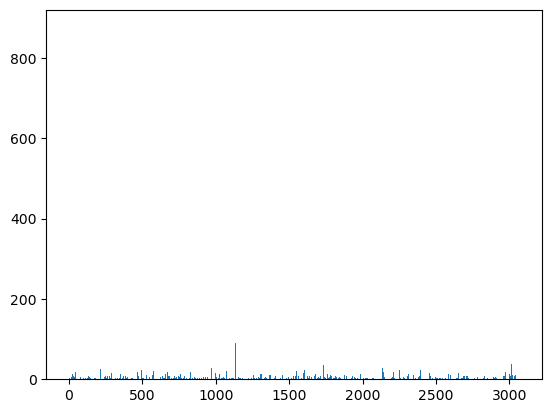

In [22]:
#plot out the distribution for each cluster
import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(assignments.cpu().numpy(), return_counts=True)
plt.bar(unique, counts)

In [23]:
np.sum(counts)

16384

In [24]:
assignments.shape

torch.Size([16384])